# Dataset: UNSW-NB15

In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append('--link to your project root directory--')
from Functions import *
from Feature_Rankers import *

In [ ]:
# Define the file path
file_path = "--path to your dataset--"
# Set the chunk size
chunk_size = 10000

# Get the logger instance
logger, dataset_name = get_logger(file_path)

In [3]:
start_time_total = time.time()
combined_data = []

# Read and process the CSV file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False, index_col=0):
    chunk = process_chunk(chunk, logger)
    chunk = downcast_dtypes(chunk, logger)
    chunk = reduce_float_precision(chunk, decimals=6, logger=logger)
    chunk = handle_missing_values(chunk, method='drop', axis=0, fill_value=None)
    combined_data.append(chunk)

# Combine all processed chunks into a single DataFrame
df = pd.concat(combined_data, ignore_index=True)
del combined_data  # Free up memory
gc.collect()
logger.info(f"Combined DataFrame shape: {df.shape}")

# Plot and save the correlation matrix
plot_and_save_correlation_matrix(df, file_path, logger, dpi= 400)

# Log the total time taken
end_time_total = time.time()
logger.info(f"Total processing time: {end_time_total - start_time_total:.2f} seconds")

2024-09-16 17:42:15,906 - INFO - Processing a chunk of data.
2024-09-16 17:42:15,931 - INFO - Encoding categorical features: ['dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']
2024-09-16 17:42:15,949 - INFO - Downcasting data types for memory optimization.
2024-09-16 17:42:15,953 - INFO - Memory usage before downcasting: 3.74 MB
2024-09-16 17:42:15,965 - INFO - Memory usage after downcasting: 1.91 MB
2024-09-16 17:42:15,966 - INFO - Memory reduction: 49.0%
2024-09-16 17:42:15,966 - INFO - Reducing float precision to 6 decimals.
2024-09-16 17:42:16,015 - INFO - Processing a chunk of data.
2024-09-16 17:42:16,031 - INFO - Encoding categorical features: ['dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']
2024-09-16 17:42:16,041 - INFO - Downcasting data types for memory optimization.
2024-09-16 17:42:16,043 - INFO - Memory usage before downcasting: 3.74 MB
2024-09-16 17:42:16,051 - INFO - Memory usage after downcasting: 1.91 MB
2024-09-16 17:42:16,052 - INFO - Memor

In [4]:
df.head(5)

,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,33661,23,9,4,0,0.036133,528,304,31.0,29.0,...,0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,2.0,0.0
1,1464,21,1810,4,0,0.001119,146,178,31.0,29.0,...,0,12.0,8.0,1.0,2.0,2.0,1.0,1.0,2.0,0.0
2,3593,19,1810,4,0,0.001209,132,164,31.0,29.0,...,0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
3,49664,4,1810,4,0,0.001169,146,178,31.0,29.0,...,0,7.0,9.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
4,32119,23,50,4,0,0.078339,568,312,31.0,29.0,...,0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,2.0,0.0


In [5]:
df= df[df['attack_cat'] != 8.0]
df['attack_cat'].value_counts()
df=df.drop(columns=['Label'])
df.head(5)

,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
0,33661,23,9,4,0,0.036133,528,304,31.0,29.0,...,0.0,0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,2.0
1,1464,21,1810,4,0,0.001119,146,178,31.0,29.0,...,0.0,0,12.0,8.0,1.0,2.0,2.0,1.0,1.0,2.0
2,3593,19,1810,4,0,0.001209,132,164,31.0,29.0,...,0.0,0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,2.0
3,49664,4,1810,4,0,0.001169,146,178,31.0,29.0,...,0.0,0,7.0,9.0,1.0,1.0,1.0,1.0,1.0,2.0
4,32119,23,50,4,0,0.078339,568,312,31.0,29.0,...,0.0,0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,2.0


In [6]:
df['attack_cat'].isna().sum()

0

In [7]:
# Specify the class label
class_label = "attack_cat"
# Split the data into training and testing sets
train_df, X_test, y_test = split_data(df, class_label, test_size=0.2, random_state=42, logger=logger)
del df  # Free up memory
gc.collect()
# Create subsets from the training DataFrame
subsets = create_subsets(train_df, class_label, num_subsets=4, logger=logger)

for subset_index, subset_df in subsets:
    logger.info(f"Subset {subset_index} shape: {subset_df.shape}")

2024-09-16 17:42:50,852 - INFO - Splitting data into training and testing sets.
2024-09-16 17:42:50,979 - INFO - Normalizing data...
2024-09-16 17:42:52,218 - INFO - Normalization complete.
2024-09-16 17:42:53,191 - INFO - Data split complete. Training data shape: (969603, 46), Testing data shape: (242401, 46)
2024-09-16 17:42:53,324 - INFO - Created 4 subsets from the training DataFrame.
2024-09-16 17:42:53,325 - INFO - Subset 0 shape: (969603, 13)
2024-09-16 17:42:53,326 - INFO - Subset 1 shape: (969603, 13)
2024-09-16 17:42:53,326 - INFO - Subset 2 shape: (969603, 12)
2024-09-16 17:42:53,327 - INFO - Subset 3 shape: (969603, 12)


In [8]:
logger.info("Ranking and evaluating features with MRMR...")
all_results_mrmr = parallel_rank_and_evaluate(subsets, mrmr, class_label, n_features= 6, n_iter= 10,n_jobs=-1, logger=logger)

logger.info("Ranking and evaluating features with JOMIC...")
all_results_jomic = parallel_rank_and_evaluate(subsets, jomic, class_label, n_features= 6,n_iter= 10,n_jobs=-1, logger=logger)

logger.info("Ranking and evaluating features with MIFSND...")
all_results_MIFSND = parallel_rank_and_evaluate(subsets, MIFSND, class_label, n_features= 6, n_iter= 10,n_jobs=-1, logger=logger)

logger.info("Ranking and evaluating features with PCrr...")
all_results_PCrr = parallel_rank_and_evaluate(subsets, PCrr, class_label, n_features= 6, n_iter= 10,n_jobs=-1, logger=logger)

logger.info("MRMR results:")
for result in all_results_mrmr:
    logger.info(f"Subset ID: {result['subset_id']}, Best Iteration: {result['best_iteration']}, Max Accuracy: {result['max_accuracy']:.4f}, Best Features: {result['best_features']}")

logger.info("JOMIC results:")
for result in all_results_jomic:
    logger.info(f"Subset ID: {result['subset_id']}, Best Iteration: {result['best_iteration']}, Max Accuracy: {result['max_accuracy']:.4f}, Best Features: {result['best_features']}")

logger.info("MIFSND results:")
for result in all_results_MIFSND:
    logger.info(f"Subset ID: {result['subset_id']}, Best Iteration: {result['best_iteration']}, Max Accuracy: {result['max_accuracy']:.4f}, Best Features: {result['best_features']}")

logger.info("PCrr results:")
for result in all_results_PCrr:
    logger.info(f"Subset ID: {result['subset_id']}, Best Iteration: {result['best_iteration']}, Max Accuracy: {result['max_accuracy']:.4f}, Best Features: {result['best_features']}")


2024-09-16 17:43:44,344 - INFO - Ranking and evaluating features with MRMR...
2024-09-16 19:07:58,581 - INFO - Ranking and evaluation with mrmr took 5054.18 seconds
2024-09-16 19:07:58,584 - INFO - Ranking and evaluating features with JOMIC...


Filename: /home/tejmani/Desktop/Chinglensana/New/Functions.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   258   2232.1 MiB   2232.1 MiB           1   @profile
   259                                         def parallel_rank_and_evaluate(df_subsets, ranking_func, class_label, n_features, n_iter, n_jobs, logger):
   260   2232.1 MiB      0.0 MiB           1       start_time = time.time()
   261   2248.2 MiB     16.1 MiB          16       results = Parallel(n_jobs=n_jobs)(
   262   2232.5 MiB      0.0 MiB           4           delayed(rank_and_evaluate_single_subset)(subset_id, subset_df, ranking_func, class_label, n_features, n_iter)
   263   2232.5 MiB      0.0 MiB           5           for subset_id, subset_df in df_subsets
   264                                             )
   265   2248.2 MiB      0.0 MiB           1       elapsed_time = time.time() - start_time
   266   2248.2 MiB      0.0 MiB           1       logger.info(f"Ranking and evaluation with {rankin

2024-09-16 20:34:58,892 - INFO - Ranking and evaluation with jomic took 5220.30 seconds
2024-09-16 20:34:58,895 - INFO - Ranking and evaluating features with MIFSND...


Filename: /home/tejmani/Desktop/Chinglensana/New/Functions.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   258   2248.2 MiB   2248.2 MiB           1   @profile
   259                                         def parallel_rank_and_evaluate(df_subsets, ranking_func, class_label, n_features, n_iter, n_jobs, logger):
   260   2248.2 MiB      0.0 MiB           1       start_time = time.time()
   261   2248.2 MiB      0.0 MiB          16       results = Parallel(n_jobs=n_jobs)(
   262   2248.2 MiB      0.0 MiB           4           delayed(rank_and_evaluate_single_subset)(subset_id, subset_df, ranking_func, class_label, n_features, n_iter)
   263   2248.2 MiB      0.0 MiB           5           for subset_id, subset_df in df_subsets
   264                                             )
   265   2248.2 MiB      0.0 MiB           1       elapsed_time = time.time() - start_time
   266   2248.2 MiB      0.0 MiB           1       logger.info(f"Ranking and evaluation with {rankin

2024-09-16 21:51:44,900 - INFO - Ranking and evaluation with MIFSND took 4606.00 seconds
2024-09-16 21:51:44,903 - INFO - Ranking and evaluating features with PCrr...


Filename: /home/tejmani/Desktop/Chinglensana/New/Functions.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   258   2248.2 MiB   2248.2 MiB           1   @profile
   259                                         def parallel_rank_and_evaluate(df_subsets, ranking_func, class_label, n_features, n_iter, n_jobs, logger):
   260   2248.2 MiB      0.0 MiB           1       start_time = time.time()
   261   2248.2 MiB      0.0 MiB          16       results = Parallel(n_jobs=n_jobs)(
   262   2248.2 MiB      0.0 MiB           4           delayed(rank_and_evaluate_single_subset)(subset_id, subset_df, ranking_func, class_label, n_features, n_iter)
   263   2248.2 MiB      0.0 MiB           5           for subset_id, subset_df in df_subsets
   264                                             )
   265   2248.2 MiB      0.0 MiB           1       elapsed_time = time.time() - start_time
   266   2248.2 MiB      0.0 MiB           1       logger.info(f"Ranking and evaluation with {rankin

2024-09-16 22:56:38,462 - INFO - Ranking and evaluation with PCrr took 3893.56 seconds
2024-09-16 22:56:38,465 - INFO - MRMR results:
2024-09-16 22:56:38,466 - INFO - Subset ID: 0, Best Iteration: 8, Max Accuracy: 0.8857, Best Features: ['dbytes', 'sbytes', 'dsport', 'dur', 'sport', 'proto']
2024-09-16 22:56:38,466 - INFO - Subset ID: 1, Best Iteration: 4, Max Accuracy: 0.3854, Best Features: ['service', 'Spkts', 'Dpkts', 'smeansz', 'dmeansz', 'dtcpb']
2024-09-16 22:56:38,467 - INFO - Subset ID: 2, Best Iteration: 6, Max Accuracy: 0.9357, Best Features: ['Ltime', 'Stime', 'Sjit', 'Djit', 'Dintpkt', 'Sintpkt']
2024-09-16 22:56:38,468 - INFO - Subset ID: 3, Best Iteration: 10, Max Accuracy: 0.8142, Best Features: ['ct_srv_dst', 'ct_srv_src', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_state_ttl']
2024-09-16 22:56:38,468 - INFO - JOMIC results:
2024-09-16 22:56:38,469 - INFO - Subset ID: 0, Best Iteration: 4, Max Accuracy: 0.8370, Best Features: ['dsport', 'dloss', 'dur', 'proto

Filename: /home/tejmani/Desktop/Chinglensana/New/Functions.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   258   2248.2 MiB   2248.2 MiB           1   @profile
   259                                         def parallel_rank_and_evaluate(df_subsets, ranking_func, class_label, n_features, n_iter, n_jobs, logger):
   260   2248.2 MiB      0.0 MiB           1       start_time = time.time()
   261   2248.2 MiB      0.0 MiB          16       results = Parallel(n_jobs=n_jobs)(
   262   2248.2 MiB      0.0 MiB           4           delayed(rank_and_evaluate_single_subset)(subset_id, subset_df, ranking_func, class_label, n_features, n_iter)
   263   2248.2 MiB      0.0 MiB           5           for subset_id, subset_df in df_subsets
   264                                             )
   265   2248.2 MiB      0.0 MiB           1       elapsed_time = time.time() - start_time
   266   2248.2 MiB      0.0 MiB           1       logger.info(f"Ranking and evaluation with {rankin

In [9]:
combined_features = get_combined_features([all_results_mrmr, all_results_jomic, all_results_MIFSND, all_results_PCrr],
                                           min_ranker_agreement=3)
logger.info(f"Combined selected features: {combined_features}")
reduced_features = drop_highly_correlated_features(train_df,combined_features, threshold=0.8, logger=logger)
logger.info(f"Optimal features: {reduced_features}")

2024-09-16 22:56:38,479 - INFO - Combined selected features: ['dbytes', 'dsport', 'dur', 'proto', 'service', 'smeansz', 'dmeansz', 'dtcpb', 'Ltime', 'Stime', 'Dintpkt', 'Sintpkt', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_state_ttl', 'dloss', 'res_bdy_len', 'is_sm_ips_ports']
2024-09-16 22:56:39,134 - INFO - Dropping 4 features due to high correlation.
2024-09-16 22:56:39,135 - INFO - Features dropped due to high correlation: ['Stime', 'is_ftp_login', 'dloss', 'is_sm_ips_ports']
2024-09-16 22:56:39,136 - INFO - Selected 15 out of 47 features.
2024-09-16 22:56:39,136 - INFO - Optimal features: ['dbytes', 'dsport', 'dur', 'proto', 'service', 'smeansz', 'dmeansz', 'dtcpb', 'Ltime', 'Dintpkt', 'Sintpkt', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_state_ttl', 'res_bdy_len']


In [10]:
display_correlation_of_selected_features(train_df, reduced_features, dataset_name, dpi=400, logger=logger)

2024-09-16 22:56:39,142 - INFO - Displaying correlation matrix for optimal features from UNSW-NB15_full.
2024-09-16 22:56:40,085 - INFO - Optimal features correlation matrix saved as UNSW-NB15_full_correlation_optimal.png


2024-09-16 22:56:40,091 - INFO - Performing cross-validation...
2024-09-16 22:56:40,120 - INFO - Evaluating RandomForest without SMOTE...
2024-09-16 22:58:41,145 - INFO - RandomForest without SMOTE - Cross-validation took 121.02 seconds
2024-09-16 22:58:41,149 - INFO - RandomForest without SMOTE - Accuracy: 0.9666 ± 0.0003
2024-09-16 22:58:41,150 - INFO - RandomForest without SMOTE - Precision: 0.9749 ± 0.0002
2024-09-16 22:58:41,151 - INFO - RandomForest without SMOTE - Recall: 0.9666 ± 0.0003
2024-09-16 22:58:41,152 - INFO - RandomForest without SMOTE - F1: 0.9699 ± 0.0002
2024-09-16 22:58:41,152 - INFO - RandomForest without SMOTE - Mcc: 0.9567 ± 0.0003
2024-09-16 22:58:41,153 - INFO - RandomForest without SMOTE - Fpr: 0.0112 ± 0.0008
2024-09-16 22:58:41,153 - INFO - RandomForest without SMOTE - Dr: 0.9986 ± 0.0012
2024-09-16 22:58:41,154 - INFO - Evaluating RandomForest with SMOTE...
2024-09-16 23:06:04,304 - INFO - RandomForest with SMOTE - Cross-validation took 443.15 seconds
202

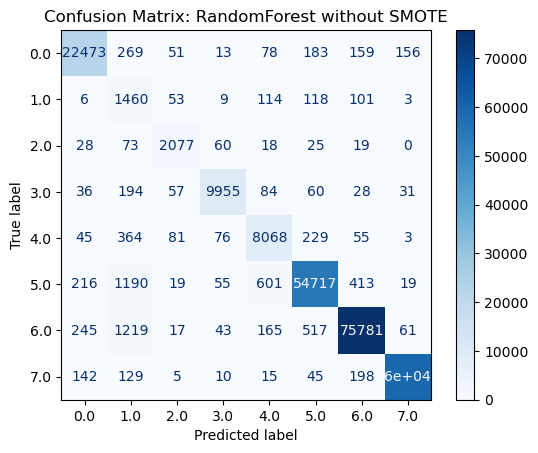

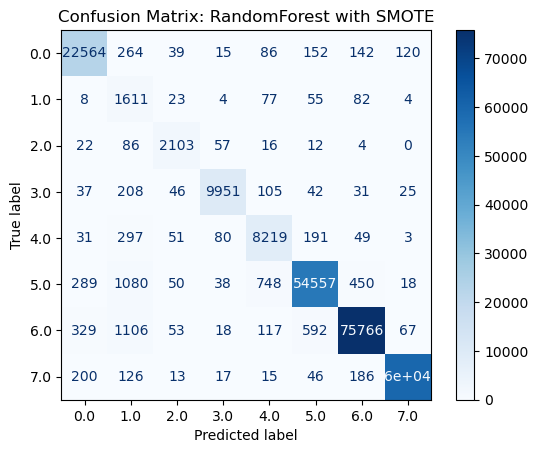

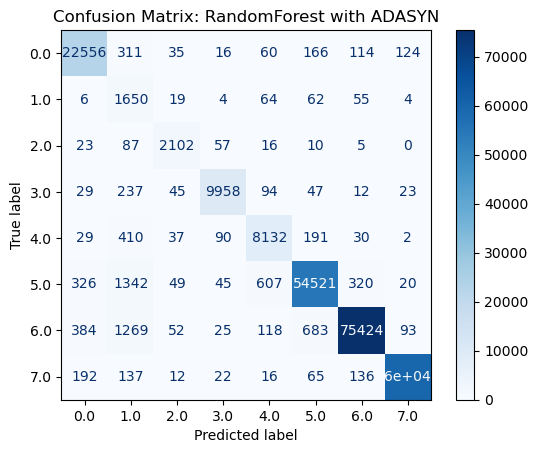

2024-09-16 23:20:33,327 - INFO - Evaluating AdaBoost without SMOTE...
/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tejmani/Desktop/Chinglensana/New/Functions.py:355: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fn)
/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tejmani/Desktop/Chinglensana/New/Functions.py:355: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fn)
/anaconda3/lib/python3.11/site-packages/sklearn/metr

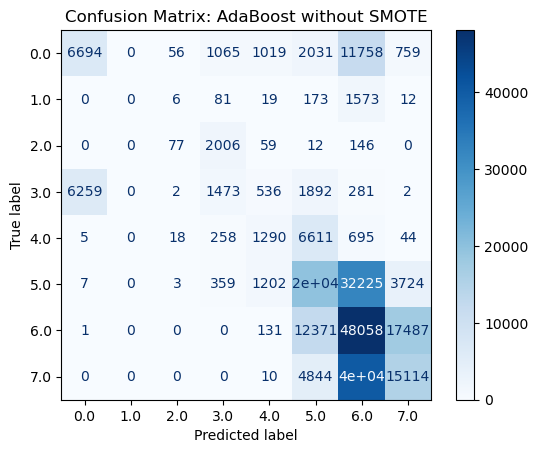

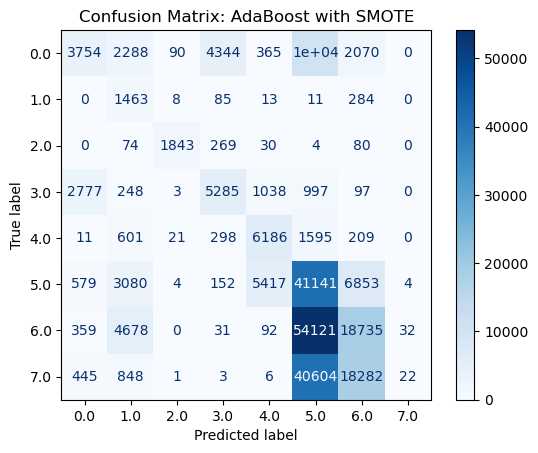

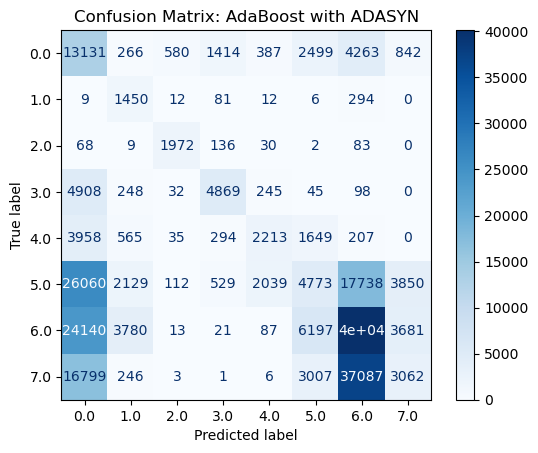

2024-09-16 23:34:11,258 - INFO - Evaluating DecisionTree without SMOTE...
2024-09-16 23:34:24,175 - INFO - DecisionTree without SMOTE - Cross-validation took 12.92 seconds
2024-09-16 23:34:24,179 - INFO - DecisionTree without SMOTE - Accuracy: 0.9709 ± 0.0003
2024-09-16 23:34:24,185 - INFO - DecisionTree without SMOTE - Precision: 0.9706 ± 0.0003
2024-09-16 23:34:24,186 - INFO - DecisionTree without SMOTE - Recall: 0.9709 ± 0.0003
2024-09-16 23:34:24,187 - INFO - DecisionTree without SMOTE - F1: 0.9707 ± 0.0003
2024-09-16 23:34:24,188 - INFO - DecisionTree without SMOTE - Mcc: 0.9619 ± 0.0004
2024-09-16 23:34:24,189 - INFO - DecisionTree without SMOTE - Fpr: 0.0010 ± 0.0003
2024-09-16 23:34:24,190 - INFO - DecisionTree without SMOTE - Dr: 0.9480 ± 0.0037
2024-09-16 23:34:24,190 - INFO - Evaluating DecisionTree with SMOTE...
2024-09-16 23:36:17,091 - INFO - DecisionTree with SMOTE - Cross-validation took 112.90 seconds
2024-09-16 23:36:17,092 - INFO - DecisionTree with SMOTE - Accuracy:

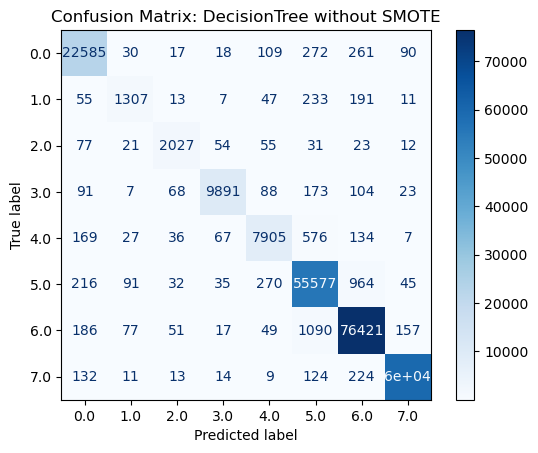

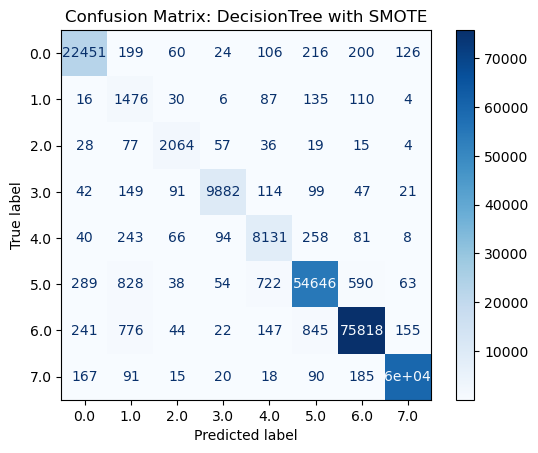

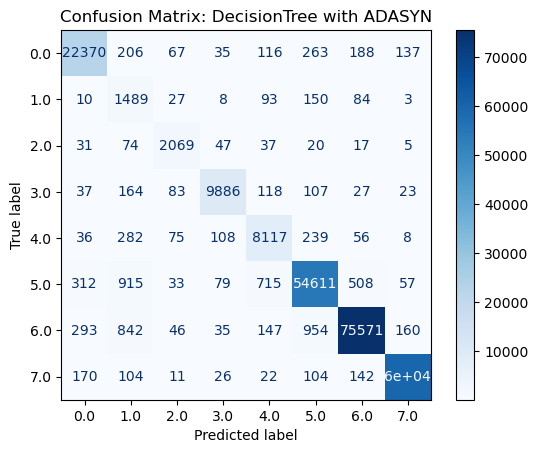

2024-09-16 23:44:17,611 - INFO - Evaluating LogisticRegression without SMOTE...
/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

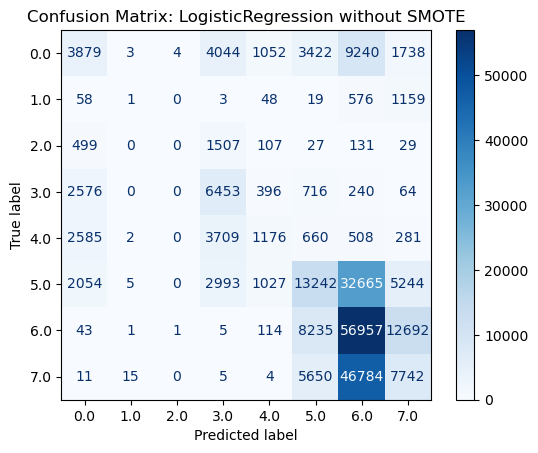

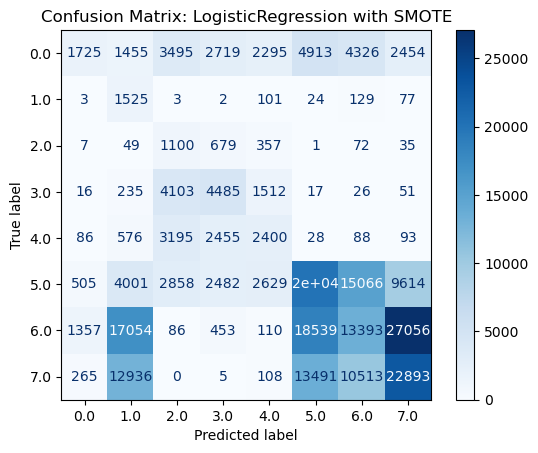

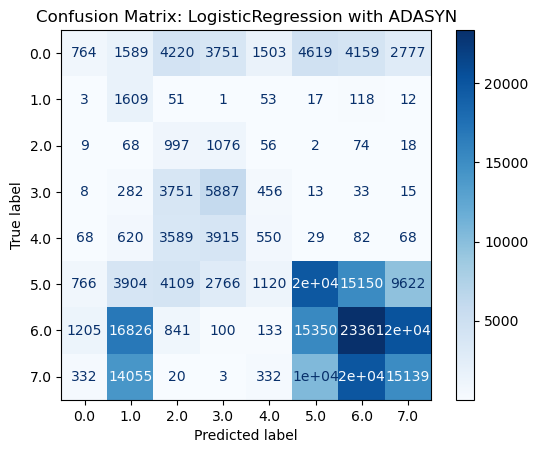

2024-09-16 23:56:37,472 - INFO - Evaluating NaiveBayes without SMOTE...
2024-09-16 23:56:44,889 - INFO - NaiveBayes without SMOTE - Cross-validation took 7.42 seconds
2024-09-16 23:56:44,892 - INFO - NaiveBayes without SMOTE - Accuracy: 0.1965 ± 0.0559
2024-09-16 23:56:44,899 - INFO - NaiveBayes without SMOTE - Precision: 0.3786 ± 0.0112
2024-09-16 23:56:44,899 - INFO - NaiveBayes without SMOTE - Recall: 0.1965 ± 0.0559
2024-09-16 23:56:44,900 - INFO - NaiveBayes without SMOTE - F1: 0.1604 ± 0.0211
2024-09-16 23:56:44,901 - INFO - NaiveBayes without SMOTE - Mcc: 0.0947 ± 0.0288
2024-09-16 23:56:44,901 - INFO - NaiveBayes without SMOTE - Fpr: 0.8508 ± 0.0427
2024-09-16 23:56:44,902 - INFO - NaiveBayes without SMOTE - Dr: 0.9971 ± 0.0005
2024-09-16 23:56:44,903 - INFO - Evaluating NaiveBayes with SMOTE...
2024-09-16 23:58:15,024 - INFO - NaiveBayes with SMOTE - Cross-validation took 90.12 seconds
2024-09-16 23:58:15,026 - INFO - NaiveBayes with SMOTE - Accuracy: 0.1108 ± 0.0059
2024-09-1

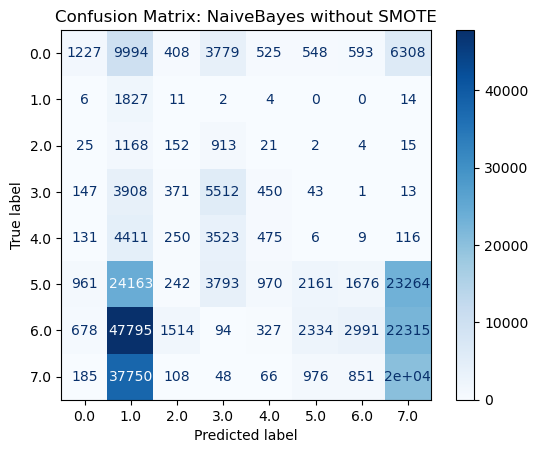

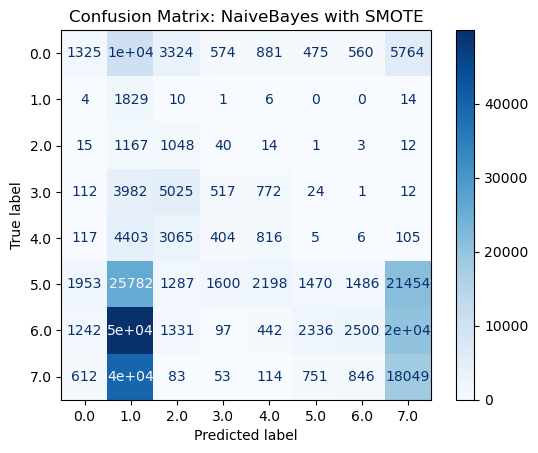

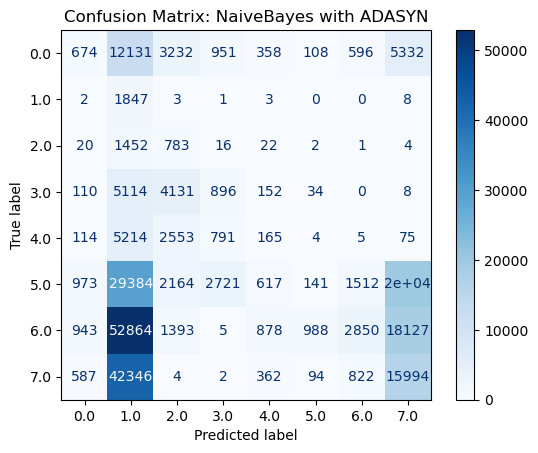

2024-09-17 00:05:52,936 - INFO - Evaluating XGBoost without SMOTE...
2024-09-17 00:06:43,910 - INFO - XGBoost without SMOTE - Cross-validation took 50.97 seconds
2024-09-17 00:06:43,919 - INFO - XGBoost without SMOTE - Accuracy: 0.9699 ± 0.0005
2024-09-17 00:06:43,921 - INFO - XGBoost without SMOTE - Precision: 0.9698 ± 0.0006
2024-09-17 00:06:43,922 - INFO - XGBoost without SMOTE - Recall: 0.9699 ± 0.0005
2024-09-17 00:06:43,923 - INFO - XGBoost without SMOTE - F1: 0.9697 ± 0.0006
2024-09-17 00:06:43,924 - INFO - XGBoost without SMOTE - Mcc: 0.9607 ± 0.0007
2024-09-17 00:06:43,925 - INFO - XGBoost without SMOTE - Fpr: 0.0000 ± 0.0000
2024-09-17 00:06:43,926 - INFO - XGBoost without SMOTE - Dr: 0.9691 ± 0.0047
2024-09-17 00:06:43,926 - INFO - Evaluating XGBoost with SMOTE...
2024-09-17 00:10:02,444 - INFO - XGBoost with SMOTE - Cross-validation took 198.52 seconds
2024-09-17 00:10:02,446 - INFO - XGBoost with SMOTE - Accuracy: 0.9592 ± 0.0005
2024-09-17 00:10:02,449 - INFO - XGBoost wi

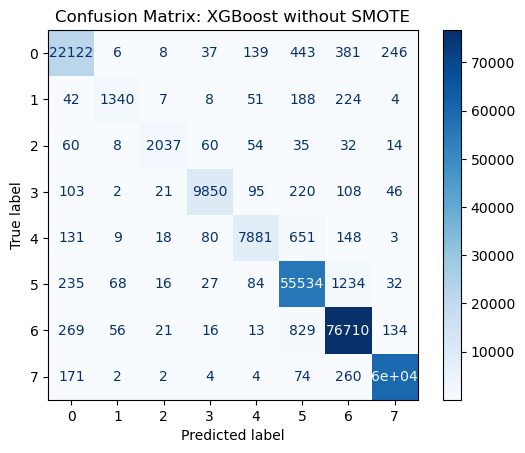

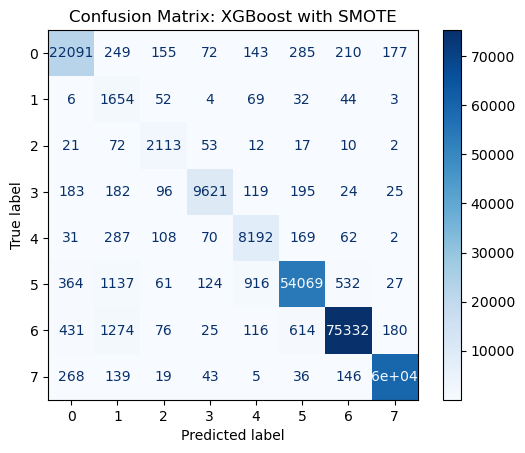

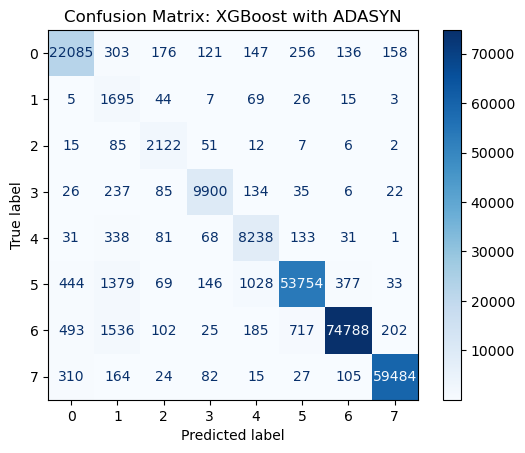

Filename: /home/tejmani/Desktop/Chinglensana/New/Functions.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   382   2248.2 MiB   2248.2 MiB           1   @profile
   383                                         def cross_validate_model(train_df, X_test, y_test, selected_features, class_label, logger):
   384   2248.2 MiB      0.0 MiB           1       mcc_scorer = make_scorer(matthews_corrcoef)
   385   2248.2 MiB      0.0 MiB           1       fpr_scorer = make_scorer(false_positive_rate)
   386   2248.2 MiB      0.0 MiB           1       dr_scorer = make_scorer(detection_rate)
   387                                         
   388   2248.2 MiB      0.0 MiB           1       X_train = train_df[selected_features]
   389   2248.2 MiB      0.0 MiB           1       y_train = train_df[class_label]
   390   2248.2 MiB      0.0 MiB           1       X_test_selected = X_test[selected_features]
   391                                         
   392   2248.2 MiB      0.0 MiB  

In [11]:
logger.info("Performing cross-validation...")
cross_validate_model(train_df, X_test, y_test, reduced_features, class_label, logger=logger)
